In [203]:
from __future__ import print_function
import os.path
import pandas as pd
import sys
sys.path.insert(0, '../JKBio/')
%load_ext autoreload
from Helper import *
%autoreload 2
%load_ext rpy2.ipython
import numpy as np
from bokeh.plotting import *
from bokeh.models import HoverTool
output_notebook()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from helper import pyDESeq2
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import MDS, TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
#from umap import UMAP

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


Loading BokehJS ...

In [204]:
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri, Formula, numpy2ri
pandas2ri.activate()
import rpy2
from rpy2.robjects.packages import importr
deseq = importr('DESeq2')
from rpy2.robjects.conversion import localconverter
import rpy2.robjects as ro

In [212]:
with localconverter(ro.default_converter + pandas2ri.converter):
    count_matrix = pandas2ri.py2rpy(pd.DataFrame([[1,0,0],[0,1,1]]).astype(bool))

In [213]:
count_matrix

X0,X1,X2
...,...,...


# we first need to recreate out RNA matrix from slamdunk's tcount files

In [4]:
location= 'data/slamseq/'

In [5]:
files = ! ls $location
files

['MV4-11_1uM_JQ1_rep-1_exp-2.tsv',
 'MV4-11_1uM_JQ1_rep-2_exp-2.tsv',
 'MV4-11_1uM_JQ1_rep-3_exp-2.tsv',
 'MV4-11_5uM_JQ1_rep-1_exp-2.tsv',
 'MV4-11_5uM_JQ1_rep-2_exp-2.tsv',
 'MV4-11_5uM_JQ1_rep-3_exp-2.tsv',
 'MV4-11_DMSO_rep-1_exp-2.tsv',
 'MV4-11_DMSO_rep-1.tsv',
 'MV4-11_DMSO_rep-2_exp-2.tsv',
 'MV4-11_DMSO_rep-2.tsv',
 'MV4-11_DMSO_rep-3_exp-2.tsv',
 'MV4-11_DMSO_rep-3.tsv',
 'MV4-11_JQ1_rep-1.tsv',
 'MV4-11_JQ1_rep-2.tsv',
 'MV4-11_JQ1_rep-3.tsv']

In [6]:
data={}
for file in files:
    data[file.split('.')[0]]= pd.read_csv(location+file, sep='\t', comment='#',header=0)

In [7]:
prev = -2
for k,val in data.items():
    if len(set(val.Name)) != prev and prev!=-2: 
        raise ValueError('we do not have the same number of genes in each file')
    prev = len(set(val.Name))

![](images/conversionrates.png)

In [8]:
data.keys()

dict_keys(['MV4-11_1uM_JQ1_rep-1_exp-2', 'MV4-11_1uM_JQ1_rep-2_exp-2', 'MV4-11_1uM_JQ1_rep-3_exp-2', 'MV4-11_5uM_JQ1_rep-1_exp-2', 'MV4-11_5uM_JQ1_rep-2_exp-2', 'MV4-11_5uM_JQ1_rep-3_exp-2', 'MV4-11_DMSO_rep-1_exp-2', 'MV4-11_DMSO_rep-1', 'MV4-11_DMSO_rep-2_exp-2', 'MV4-11_DMSO_rep-2', 'MV4-11_DMSO_rep-3_exp-2', 'MV4-11_DMSO_rep-3', 'MV4-11_JQ1_rep-1', 'MV4-11_JQ1_rep-2', 'MV4-11_JQ1_rep-3'])

In [17]:
flag_var= 100
names, _ = convertGenes(val.Name.unique(), from_idtype="entrez_id", to_idtype="symbol")

readcounts = {i:[0]*len(data) for i in val.Name.unique()}
tccounts = {i:[0]*len(data) for i in val.Name.unique()}

for n, (_,val) in enumerate(data.items()):
    val = val.sort_values(by="Name")
    j  = 0
    print('              ',end='\r')
    readcount = [val.iloc[0].ReadCount]
    tccount = [val.iloc[0].TcReadCount]
    prevname = val.iloc[0].Name
    for _, v in val.iloc[1:].iterrows():
        if v.Name == prevname:
            readcount.append(v.ReadCount)
            tccount.append(v.TcReadCount)
        else:
            readcounts[prevname][n] = np.sum(readcount)
            tccounts[prevname][n] = np.sum(tccount)
            prevname=v.Name
            j+=1
            print(j,end='\r')
            readcount = [v.ReadCount]
            tccount = [v.TcReadCount]
            if np.var(readcount) > flag_var:
                print("pb with "+str(v.Name))
            
files = [*data]
readcounts = pd.DataFrame(data=readcounts,columns=val.Name.unique(),index=files).T
tccounts = pd.DataFrame(data=tccounts,columns=val.Name.unique(),index=files).T
readcounts.index = names
tccounts.index = names

you need access to taiga for this (https://pypi.org/project/taigapy/)
1118 could not be parsed... we don't have all genes already


In [20]:
val

,Chromosome,Start,End,Name,Length,Strand,ConversionRate,ReadsCPM,Tcontent,CoverageOnTs,ConversionsOnTs,ReadCount,TcReadCount,multimapCount,ConversionRateLower,ConversionRateUpper
35944,chr19,58346805,58347021,1,216,-,0.000000,2.030944,52,1248,0,74,0,0,-1.0,-1.0
14222,chr12,9067707,9067822,2,115,-,0.000000,0.027445,36,31,0,1,0,0,-1.0,-1.0
42459,chr12,9233385,9233692,3,307,-,0.000000,0.000000,77,0,0,0,0,0,-1.0,-1.0
42460,chr12,9234134,9234207,3,73,-,0.000000,0.000000,14,0,0,0,0,0,-1.0,-1.0
42452,chr12,9228532,9228698,3,166,-,0.000000,0.000000,40,0,0,0,0,0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33888,chr16,29442904,29443688,107282092,784,-,0.070866,0.274452,314,127,9,10,2,10,-1.0,-1.0
8628,chr13,49528665,49528991,107303344,326,+,0.001964,12.844348,110,13241,26,468,11,0,-1.0,-1.0
7168,chr1,193057280,193057415,107397392,135,-,0.086538,0.301897,40,208,18,11,10,0,-1.0,-1.0
43745,chr4,100395126,100395247,107399301,121,-,0.000000,0.000000,38,0,0,0,0,0,-1.0,-1.0


In [22]:
tccounts.loc["RTP2"]

MV4-11_1uM_JQ1_rep-1_exp-2    0
MV4-11_1uM_JQ1_rep-2_exp-2    0
MV4-11_1uM_JQ1_rep-3_exp-2    0
MV4-11_5uM_JQ1_rep-1_exp-2    0
MV4-11_5uM_JQ1_rep-2_exp-2    0
MV4-11_5uM_JQ1_rep-3_exp-2    0
MV4-11_DMSO_rep-1_exp-2       0
MV4-11_DMSO_rep-1             0
MV4-11_DMSO_rep-2_exp-2       1
MV4-11_DMSO_rep-2             0
MV4-11_DMSO_rep-3_exp-2       0
MV4-11_DMSO_rep-3             0
MV4-11_JQ1_rep-1              0
MV4-11_JQ1_rep-2              0
MV4-11_JQ1_rep-3              0
Name: RTP2, dtype: int64

## SLAM-seq
All SLAM-seq assays were performed at 60-70% confluency for adherent cells or
60% of the maximum cell density counted on a hemocytometer for suspension cells. 5-7h
prior to each assay, growth medium was aspirated and replaced. Unless stated otherwise,
cells were pre-treated with indicated small molecule inhibitors or 100µM IAA for 30 min
to pre-establish full target inhibition or degradation. Newly synthesized RNA was labeled
for indicated time spans (45 min or 60 min) at a final concentration of 100µM 4-
thiouridine (4sU, Carbosynth). Adherent cells were harvested by direct snap-freezing of
plates on dry ice. Suspension cells were spun down and immediately snap-frozen. RNA
extraction was performed using the RNeasy Plus Mini Kit (Qiagen). 

Total RNA was subjected to alkylation by iodoacetamide (Sigma, 10mM) for 15 min and RNA was repurified by ethanol precipitation. 500ng alkylated RNA were used as input for generating
3’-end mRNA sequencing libraries using a commercially available kit (QuantSeq 3′
mRNA-Seq Library Prep Kit FWD for Illumina and PCR Add-on Kit for Illumina,
Lexogen). Deep sequencing was performed using HiSeq1500 and HiSeq2500 platforms
(Illumina).

In [23]:
tccounts.shape

(25420, 15)

In [16]:
# we have a number of non zero similar to nb of prot coding genes
np.count_nonzero(tccounts.values)/15

11768.866666666667

In [106]:
readcounts.columns

Index(['MV4-11_1uM_JQ1_rep-1_exp-2', 'MV4-11_1uM_JQ1_rep-2_exp-2',
       'MV4-11_1uM_JQ1_rep-3_exp-2', 'MV4-11_5uM_JQ1_rep-1_exp-2',
       'MV4-11_5uM_JQ1_rep-2_exp-2', 'MV4-11_5uM_JQ1_rep-3_exp-2',
       'MV4-11_DMSO_rep-1_exp-2', 'MV4-11_DMSO_rep-1',
       'MV4-11_DMSO_rep-2_exp-2', 'MV4-11_DMSO_rep-2',
       'MV4-11_DMSO_rep-3_exp-2', 'MV4-11_DMSO_rep-3', 'MV4-11_JQ1_rep-1',
       'MV4-11_JQ1_rep-2', 'MV4-11_JQ1_rep-3'],
      dtype='object')

In [110]:
val[val.Name == 5292]

,Chromosome,Start,End,Name,Length,Strand,ConversionRate,ReadsCPM,Tcontent,CoverageOnTs,ConversionsOnTs,ReadCount,TcReadCount,multimapCount,ConversionRateLower,ConversionRateUpper
48552,chr6,37174091,37175428,5292,1337,+,0.0401,47.589957,415,54339,2179,1734,695,21,-1.0,-1.0


filter some more

In [109]:
convertGenes(['PIM1'], from_idtype="symbol", to_idtype="entrez_id")

you need access to taiga for this (https://pypi.org/project/taigapy/)
0 could not be parsed... we don't have all genes already


([5292.0], [])

In [59]:
tccounts

,MV4-11_1uM_JQ1_rep-1_exp-2,MV4-11_1uM_JQ1_rep-2_exp-2,MV4-11_1uM_JQ1_rep-3_exp-2,MV4-11_5uM_JQ1_rep-1_exp-2,MV4-11_5uM_JQ1_rep-2_exp-2,MV4-11_5uM_JQ1_rep-3_exp-2,MV4-11_DMSO_rep-1_exp-2,MV4-11_DMSO_rep-2_exp-2,MV4-11_DMSO_rep-3_exp-2,MV4-11_DMSO_rep-1,MV4-11_DMSO_rep-2,MV4-11_DMSO_rep-3,MV4-11_JQ1_rep-1,MV4-11_JQ1_rep-2,MV4-11_JQ1_rep-3
NAT1,109,114,133,110,132,89,89,56,53,134,117,178,117,258,139
AAMP,146,99,119,145,185,71,233,105,61,93,89,141,60,153,93
AARS1,18,7,21,30,32,13,106,63,86,47,46,66,26,30,36
ABAT,3,0,1,0,1,1,1,1,3,3,2,7,2,6,3
ABCA1,1,1,0,2,3,0,6,5,6,9,9,24,3,7,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BUB1B-PAK6,0,1,0,0,0,1,2,3,1,1,1,1,3,1,1
107080638,9,4,5,6,9,6,14,2,4,1,6,8,2,18,5
BOLA2-SMG1P6,0,0,2,1,0,2,4,0,2,6,1,3,1,2,2
107303344,0,1,2,1,4,2,0,10,21,23,7,11,3,16,11


In [24]:
toremove = np.argwhere(readcounts.values.var(1)==0)

In [25]:
len(toremove)

4538

In [26]:
set(readcounts.iloc[toremove.ravel()].index)

{'BIN3-IT1',
 'HEPACAM',
 'LINC01858',
 'RNU105C',
 'ABCA1',
 'UBL4B',
 'LINC01317',
 'PLBD1-AS1',
 'MLH1',
 'CTNNA2',
 'POU3F3',
 'PTGES2-AS1',
 'PDP2',
 'INO80C',
 'NTS',
 'MIR6743',
 'MIR6771',
 'TRAPPC4',
 'DEFB106A',
 'NUCB2',
 'WNT9A',
 'CCL14',
 'MIR516A2',
 'NHP2',
 'LINC02696',
 'PRUNE2',
 'SNORD59A',
 'LINC00208',
 'SNORD128',
 'LIPM',
 'TMEM161B-AS1',
 'CLPS',
 'MIR5689',
 'LINC01193',
 'HERC2P2',
 'SCYL1',
 'SNX33',
 'DOLPP1',
 'LINC02097',
 'MXRA8',
 254028,
 'YTHDF3-AS1',
 'PAPPA-AS1',
 'EFCAB6',
 'CPSF6',
 'RPS6KA6',
 'OR1N2',
 'NLRP10',
 'DDX59-AS1',
 'PTF1A',
 'SLC22A3',
 'DDX47',
 'SMARCAD1',
 'CLN6',
 'GDAP1',
 'DYRK1B',
 'CMA1',
 'PRMT6',
 'LINC00842',
 'IYD',
 'TNFRSF21',
 'LGI4',
 'RPS15',
 'UCP1',
 'LINC02649',
 'TMEM14C',
 'MIR4643',
 'LINC01859',
 'SPANXN5',
 'ATP10B',
 'MME',
 'LINGO2',
 729220,
 'RNA5S12',
 'DIO2-AS1',
 'SAMMSON',
 'LINC01851',
 'OR5H14',
 'SNAR-A11',
 'CLMN',
 'PNO1',
 'UGT2A3',
 'HSP90AB4P',
 'SNORD90',
 'APPL2',
 'LINC01001',
 'LPCAT1',
 '

In [26]:
readcounts = readcounts.drop(readcounts.iloc[toremove.ravel()].index,0)
tccounts = tccounts.drop(tccounts.iloc[toremove.ravel()].index,0)

In [32]:
toremove = np.argwhere(tccounts.values.max(1)<3)

In [33]:
len(toremove.ravel())

8353

In [34]:
readcounts = readcounts.drop(readcounts.iloc[toremove.ravel()].index,0)
tccounts = tccounts.drop(tccounts.iloc[toremove.ravel()].index,0)

In [35]:
len(readcounts)

12529

In [52]:
tccounts.loc['MYC']

MV4-11_1uM_JQ1_rep-1_exp-2      56
MV4-11_1uM_JQ1_rep-2_exp-2      84
MV4-11_1uM_JQ1_rep-3_exp-2      63
MV4-11_5uM_JQ1_rep-1_exp-2      50
MV4-11_5uM_JQ1_rep-2_exp-2      38
MV4-11_5uM_JQ1_rep-3_exp-2      42
MV4-11_DMSO_rep-1_exp-2        379
MV4-11_DMSO_rep-1             2033
MV4-11_DMSO_rep-2_exp-2        213
MV4-11_DMSO_rep-2             1571
MV4-11_DMSO_rep-3_exp-2        486
MV4-11_DMSO_rep-3             2830
MV4-11_JQ1_rep-1               904
MV4-11_JQ1_rep-2              1574
MV4-11_JQ1_rep-3              1008
Name: MYC, dtype: int64

# lets look at the similarity accross replicates

we have some outliers, else it seems to make some sense and on average, to be extremelly similar!

In [53]:
tccounts = tccounts[tccounts.columns[[0,1,2,3,4,5,6,8,10,7,9,11,12,13,14]]]

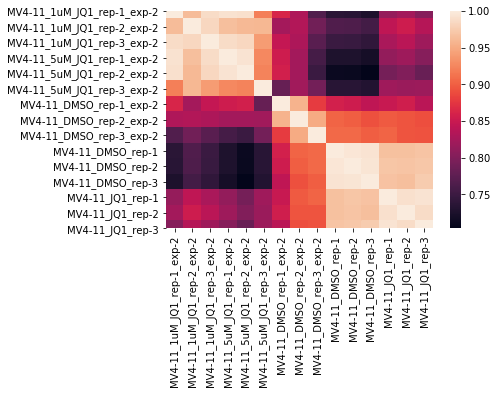

In [54]:
%matplotlib inline
sns.heatmap(tccounts.corr(), 
            xticklabels=tccounts.columns.values,
            yticklabels=tccounts.columns.values)

In [55]:
readcounts = readcounts[readcounts.columns[[0,1,2,3,4,5,6,8,10,7,9,11,12,13,14]]]

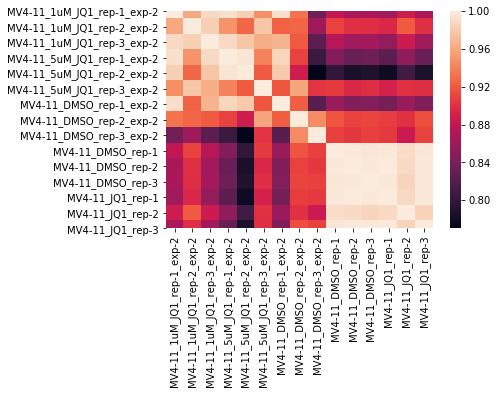

In [56]:
%matplotlib inline
sns.heatmap(readcounts.corr(), 
            xticklabels=readcounts.columns.values,
            yticklabels=readcounts.columns.values)

read the paper for MV411 QC steps.

### A quick detour to look for clustering

## Getting the Core TF information

In [69]:
ctf=pd.read_csv('data/CTF.csv',header=None)[0].values.tolist()
ctf

['MYC',
 'MYB',
 'SPI1',
 'RUNX1',
 'GSE1',
 'IRF2BP2',
 'FLI1',
 'ELF2',
 'ZEB2',
 'IKAROS',
 'GFI1',
 'LMO2',
 'CEBPA',
 'MEF2D',
 'MEF2C',
 'IRF8',
 'MEIS1',
 'RUNX2',
 'ETV6',
 'LDB1',
 'RUNX2',
 'SP1',
 'ZMYND8']

In [70]:
set(ctf) & set(tccounts.index)

{'CEBPA',
 'ELF2',
 'ETV6',
 'FLI1',
 'GFI1',
 'GSE1',
 'IRF2BP2',
 'IRF8',
 'LDB1',
 'LMO2',
 'MEF2C',
 'MEF2D',
 'MEIS1',
 'MYB',
 'MYC',
 'RUNX1',
 'RUNX2',
 'SP1',
 'SPI1',
 'ZEB2',
 'ZMYND8'}

In [71]:
ctfpos = [val for val in tccounts.index if val in ctf]
notctfpos = [val for val in tccounts.index if val not in ctf]

We find a CTF not in the dataset

In [72]:
notctfpos

['NAT1',
 'AAMP',
 'AARS1',
 'ABAT',
 'ABCA1',
 'ABCA2',
 'ABCB7',
 'ABCF1',
 'ABL1',
 'ABL2',
 'ABR',
 'ACAA1',
 'ACACA',
 'ACACB',
 'ACADM',
 'ACADS',
 'ACADSB',
 'ACADVL',
 'ACAT1',
 'ACAT2',
 'ACLY',
 'ACO1',
 'ACO2',
 'ACOX1',
 'ACP1',
 'ACP2',
 'ACPP',
 'ACTB',
 'ACTG1',
 'ACTN4',
 'ACTL6A',
 'ACTN1',
 'ACVR1',
 'ACVR1B',
 'ACVR2A',
 'ACVR2B',
 'ACVRL1',
 'ACY1',
 'ACYP1',
 'ACYP2',
 'ADA',
 'ADAM8',
 'ADAM10',
 'ADAR',
 'ADARB1',
 'ADCY1',
 'ADCY3',
 'ADCY6',
 'ADCY7',
 'ADCY9',
 'ADD1',
 'ADD2',
 'ADD3',
 'PLIN2',
 'ADH5',
 'ADK',
 'ADM',
 'ADORA1',
 'ADORA2A',
 'ADORA2B',
 'ADORA3',
 'ADPRH',
 'PARP1',
 'PARP4',
 'ADRA2C',
 'ADRB1',
 'ADRB2',
 'GRK2',
 'GRK3',
 'ADSL',
 'ADSS2',
 'AP2A1',
 'AP2A2',
 'AP1B1',
 'AP2B1',
 'AP1G1',
 'TLE5',
 'AFG3L1P',
 'AGA',
 'AGER',
 'AGL',
 'JAG1',
 'AGT',
 'AHCY',
 'AHR',
 'AIF1',
 'CRYBG1',
 'AK1',
 'AK2',
 'AK4',
 'AKT1',
 'AKT2',
 'ALAD',
 'ALAS1',
 'ALCAM',
 'ABCD1',
 'ALDH2',
 'ALDH1B1',
 'ALDH1A3',
 'ALDH3B1',
 'ALDH9A1',
 'ALDH3A2',
 '

# Let's look at how they change accross time

how core transcription factors change accross time when the cell is with JQ1 conditions

we are looking at the difference between production of each CTF compared to the average RNA production with JQ1 and without JQ1

## DESEQ ANALYSIS

In [73]:
readcounts["genes"] = readcounts.index
readcounts = readcounts.reset_index(drop=True)
tccounts["genes"] = tccounts.index
tccounts = tccounts.reset_index(drop=True)

In [74]:
tccounts.iloc[140]

MV4-11_1uM_JQ1_rep-1_exp-2      107
MV4-11_1uM_JQ1_rep-2_exp-2      105
MV4-11_1uM_JQ1_rep-3_exp-2       78
MV4-11_5uM_JQ1_rep-1_exp-2       99
MV4-11_5uM_JQ1_rep-2_exp-2      152
MV4-11_5uM_JQ1_rep-3_exp-2       67
MV4-11_DMSO_rep-1_exp-2          97
MV4-11_DMSO_rep-2_exp-2          82
MV4-11_DMSO_rep-3_exp-2         106
MV4-11_DMSO_rep-1               102
MV4-11_DMSO_rep-2                95
MV4-11_DMSO_rep-3               129
MV4-11_JQ1_rep-1                104
MV4-11_JQ1_rep-2                139
MV4-11_JQ1_rep-3                124
genes                         APLP2
Name: 140, dtype: object

In [244]:
tccounts[tccounts.genes=='ZEB2'].values[0][-7:].mean()

array([2196, 1856, 3155, 1820, 3066, 2218, 'ZEB2'], dtype=object)

In [145]:
design = pd.DataFrame(index=[i.replace('-','.') for i in tccounts.columns.values[:-1]], 
                      columns=['DMSO','JQ1'], 
                      data=np.array([[0,0,0,0,0,0,0,0,0,1,1,1,0,0,0],
                                     [0,0,0,0,0,0,0,0,0,0,0,0,1,1,1]],dtype=bool).T)

### Differential gene expression analysis, PCA and GO-term enrichment

For gene-level analysis, raw reads mapped to different UTR annotations of the same gene were summed up by Entrez Gene ID. Pilot studies of K562 cells with kinase inhibitors were performed as single experiments. 

Analysis of differential gene expression was restricted to genes with ≥ 10 reads in at least one condition for 50bp sequencing runs (flavopiridol and DMSO) or ≥ 20 reads in at least one condition for 100bp sequencing runs (mk2206, trametinib, nilotinib, trametinib + mk2206 and DMSO). For estimating differential expression, a pseudo-count of 1 raw read was added to all genes.

#### All other SLAM-seq experiments were performed in triplicates and analyzed as follows. 
Differential gene expression calling was performed on raw read counts with ≥ 2 T>C conversions using DESeq2 (version 1.14.1) with default settings, and with size factors estimated on corresponding total mRNA reads for global normalization.

Downstream analysis was restricted to genes passing all internal filters for FDR estimation by DESeq2. Principal component analysis was performed after variance
stabilizing transformation on the 500 most variable genes across all conditions of a given
experiment. GO-term enrichment analysis was performed on genes significantly and strongly downregulated (FDR ≤ 0.1, log2FC ≤ -1) in SLAM-seq upon IAA-treatment in K562MYC-AID + Tir1 by the PANTHER Overrepresentation Test (Fisher's Exact with FDR multiple test correction, release 20171205, http://pantherdb.org) on GO Ontology database Released 2017-12-27.

In [133]:
design

,DMSO,JQ1
MV4.11_1uM_JQ1_rep.1_exp.2,False,False
MV4.11_1uM_JQ1_rep.2_exp.2,False,False
MV4.11_1uM_JQ1_rep.3_exp.2,False,False
MV4.11_5uM_JQ1_rep.1_exp.2,False,False
MV4.11_5uM_JQ1_rep.2_exp.2,False,False
MV4.11_5uM_JQ1_rep.3_exp.2,False,False
MV4.11_DMSO_rep.1_exp.2,False,False
MV4.11_DMSO_rep.2_exp.2,False,False
MV4.11_DMSO_rep.3_exp.2,False,False
MV4.11_DMSO_rep.1,True,False


In [134]:
tccounts.columns = [i.replace('-','.') for i in tccounts.columns]

In [179]:
tccounts[tccounts.columns[-7:]]

,MV4.11_DMSO_rep.1,MV4.11_DMSO_rep.2,MV4.11_DMSO_rep.3,MV4.11_JQ1_rep.1,MV4.11_JQ1_rep.2,MV4.11_JQ1_rep.3,genes
0,134,117,178,117,258,139,NAT1
1,93,89,141,60,153,93,AAMP
2,47,46,66,26,30,36,AARS1
3,3,2,7,2,6,3,ABAT
4,9,9,24,3,7,8,ABCA1
...,...,...,...,...,...,...,...
12524,1,1,1,3,1,1,BUB1B-PAK6
12525,1,6,8,2,18,5,107080638
12526,6,1,3,1,2,2,BOLA2-SMG1P6
12527,23,7,11,3,16,11,107303344


In [173]:
design.iloc[-6:]

,DMSO,JQ1
MV4.11_DMSO_rep.1,True,False
MV4.11_DMSO_rep.2,True,False
MV4.11_DMSO_rep.3,True,False
MV4.11_JQ1_rep.1,False,True
MV4.11_JQ1_rep.2,False,True
MV4.11_JQ1_rep.3,False,True


In [215]:
tccounts[tccounts.columns[-7:]]

,MV4.11_DMSO_rep.1,MV4.11_DMSO_rep.2,MV4.11_DMSO_rep.3,MV4.11_JQ1_rep.1,MV4.11_JQ1_rep.2,MV4.11_JQ1_rep.3,genes
0,134,117,178,117,258,139,NAT1
1,93,89,141,60,153,93,AAMP
2,47,46,66,26,30,36,AARS1
3,3,2,7,2,6,3,ABAT
4,9,9,24,3,7,8,ABCA1
...,...,...,...,...,...,...,...
12524,1,1,1,3,1,1,BUB1B-PAK6
12525,1,6,8,2,18,5,107080638
12526,6,1,3,1,2,2,BOLA2-SMG1P6
12527,23,7,11,3,16,11,107303344


In [216]:
design.iloc[-6:]

,DMSO,JQ1
MV4.11_DMSO_rep.1,True,False
MV4.11_DMSO_rep.2,True,False
MV4.11_DMSO_rep.3,True,False
MV4.11_JQ1_rep.1,False,True
MV4.11_JQ1_rep.2,False,True
MV4.11_JQ1_rep.3,False,True


In [252]:
tccounts[tccounts.columns[-7:]]

,MV4.11_DMSO_rep.1,MV4.11_DMSO_rep.2,MV4.11_DMSO_rep.3,MV4.11_JQ1_rep.1,MV4.11_JQ1_rep.2,MV4.11_JQ1_rep.3,genes
0,134,117,178,117,258,139,NAT1
1,93,89,141,60,153,93,AAMP
2,47,46,66,26,30,36,AARS1
3,3,2,7,2,6,3,ABAT
4,9,9,24,3,7,8,ABCA1
...,...,...,...,...,...,...,...
12524,1,1,1,3,1,1,BUB1B-PAK6
12525,1,6,8,2,18,5,107080638
12526,6,1,3,1,2,2,BOLA2-SMG1P6
12527,23,7,11,3,16,11,107303344


In [253]:
design.iloc[-6:]

,DMSO,JQ1
MV4.11_DMSO_rep.1,True,False
MV4.11_DMSO_rep.2,True,False
MV4.11_DMSO_rep.3,True,False
MV4.11_JQ1_rep.1,False,True
MV4.11_JQ1_rep.2,False,True
MV4.11_JQ1_rep.3,False,True


In [226]:
deseq = pyDESeq2.pyDESeq2(count_matrix=tccounts[tccounts.columns[-7:]],
                          design_matrix=design.iloc[-6:],
                         design_formula="~DMSO - JQ1",
                         gene_column="genes")

3.2.1


In [227]:
deseq.run_estimate_size_factors(geoMeans = np.exp(np.mean(
    np.log(readcounts[readcounts.columns[6:-1]].values+1), 1)))

In [228]:
deseq.run_deseq()

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



In [229]:
deseq.get_deseq_result()

In [230]:
JQ1res = deseq.deseq_result

In [231]:
JQ1res.pvalue = np.nan_to_num(np.array(JQ1res.pvalue), 1)
JQ1res.log2FoldChange = np.nan_to_num(np.array(JQ1res.log2FoldChange), 0)

In [162]:
JQ1res

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,125.721439,-0.220863,0.406594,-0.543201,0.586991,0.834673,NAT1,NAT1
1,130.673593,-1.161617,0.439530,-2.642858,0.008221,0.206765,AAMP,AAMP
2,38.955391,-1.090033,0.437530,-2.491332,0.012727,0.239940,AARS1,AARS1
3,1.874874,0.377499,0.767333,0.491962,0.622746,NaN,ABAT,ABAT
4,4.058380,-0.229555,0.661520,-0.347011,0.728583,0.900309,ABCA1,ABCA1
...,...,...,...,...,...,...,...,...
12524,1.003823,0.314822,1.083312,0.290610,0.771349,NaN,BUB1B-PAK6,BUB1B-PAK6
12525,7.005210,-0.476820,0.677942,-0.703334,0.481848,0.773222,107080638,107080638
12526,1.608621,-0.640513,1.002922,-0.638647,0.523053,NaN,BOLA2-SMG1P6,BOLA2-SMG1P6
12527,5.987155,0.037752,0.820894,0.045989,0.963319,0.988255,107303344,107303344


In [163]:
JQ1res.to_csv("data/jq1.mv411.csv")

In [250]:
JQ1res.log2FoldChange = -JQ1res.log2FoldChange

In [165]:
ctf

['MYC',
 'MYB',
 'SPI1',
 'RUNX1',
 'GSE1',
 'IRF2BP2',
 'FLI1',
 'ELF2',
 'ZEB2',
 'IKAROS',
 'GFI1',
 'LMO2',
 'CEBPA',
 'MEF2D',
 'MEF2C',
 'IRF8',
 'MEIS1',
 'RUNX2',
 'ETV6',
 'LDB1',
 'RUNX2',
 'SP1',
 'ZMYND8']

In [233]:
JQ1res["gene_id"] = JQ1res.genes

In [251]:
show(volcano(JQ1res,tohighlight=ctf))

In [274]:
save(volcano(JQ1res,tohighlight=ctf), "data/volcano.html")

'/home/jeremie/AMLproject/data/volcano.html'